# Stock market forecasting using Time Series analysis

**Here in this notebook we will forecast the stock price bank nifty using ARIMA model**

### Load all the required libraries

In [46]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

In [47]:
df= yf.Ticker("^NSEBANK").history(period='3y').reset_index()
df_axis= yf.Ticker("AXISBANK.NS").history(period='3y').reset_index()
df_sbi= yf.Ticker("SBIN.NS").history(period='3y').reset_index()
df_rbl= yf.Ticker("RBLBANK.NS").history(period='3y').reset_index()
df_pnb= yf.Ticker("PNB.NS").history(period='3y').reset_index()
df_kot= yf.Ticker("KOTAKBANK.NS").history(period='3y').reset_index()
df_ind= yf.Ticker("INDUSINDBK.NS").history(period='3y').reset_index()
df_idfc= yf.Ticker("IDFCFIRSTB.NS").history(period='3y').reset_index()
df_icic= yf.Ticker("ICICIBANK.NS").history(period='3y').reset_index()
df_band= yf.Ticker("BANDHANBNK.NS").history(period='3y').reset_index()
df_hdfc= yf.Ticker("HDFC.NS").history(period='3y').reset_index()
df_fed= yf.Ticker("FEDERALBNK.NS").history(period='3y').reset_index()
df_au= yf.Ticker("AUBANK.NS").history(period='3y').reset_index()

In [48]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ticker='^NSEBANK'
stock_data=yf.download(ticker)

#df.head()

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

                       Date          Open          High           Low  \
0 2019-12-02 00:00:00+05:30  32008.300781  32024.099609  31720.599609   
1 2019-12-03 00:00:00+05:30  31920.099609  31936.599609  31502.949219   
2 2019-12-04 00:00:00+05:30  31549.300781  32017.750000  31444.000000   
3 2019-12-05 00:00:00+05:30  32083.800781  32126.949219  31628.300781   
4 2019-12-06 00:00:00+05:30  31797.150391  31883.699219  31250.650391   

          Close  Volume  Dividends  Stock Splits  
0  31871.449219       0          0             0  
1  31613.349609       0          0             0  
2  31979.300781  516800          0             0  
3  31712.949219  393300          0             0  
4  31341.550781  485400          0             0  


In [51]:
import plotly.express as px
fig = px.line(df, x='Date', y="Open")
fig.show()




In [54]:
fig = px.line(df, x='Date', y='Close')
fig.show()


Visualize the per day closing price of the stock.

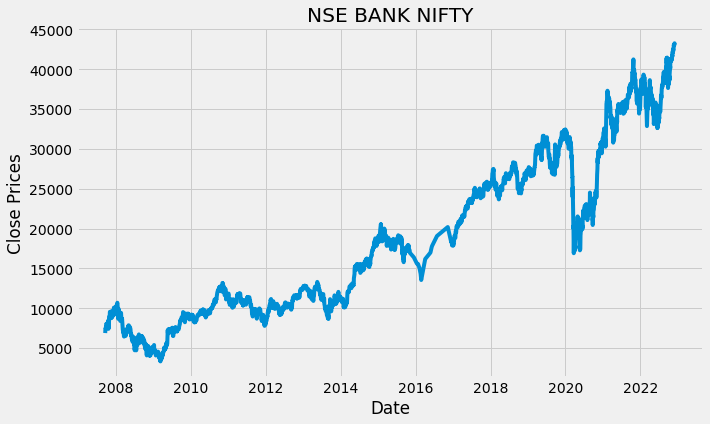

In [31]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NSE BANK NIFTY')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

<AxesSubplot:ylabel='Density'>

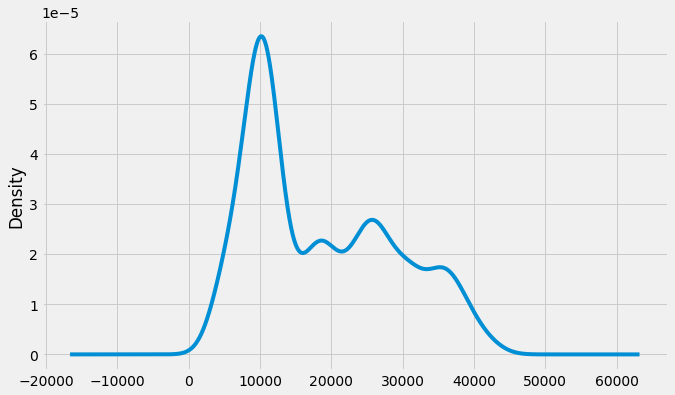

In [32]:
#Distribution of the dataset
df_close= stock_data['Close']
df_close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

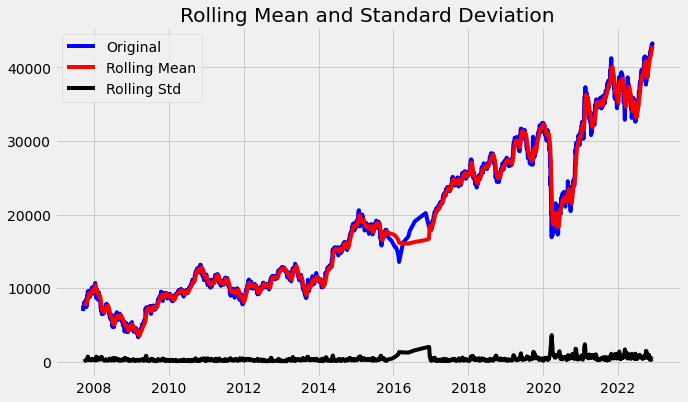

Results of dickey fuller test
Test Statistics                   0.150151
p-value                           0.969323
No. of lags used                  7.000000
Number of observations used    3449.000000
critical value (1%)              -3.432247
critical value (5%)              -2.862378
critical value (10%)             -2.567216
dtype: float64


In [33]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

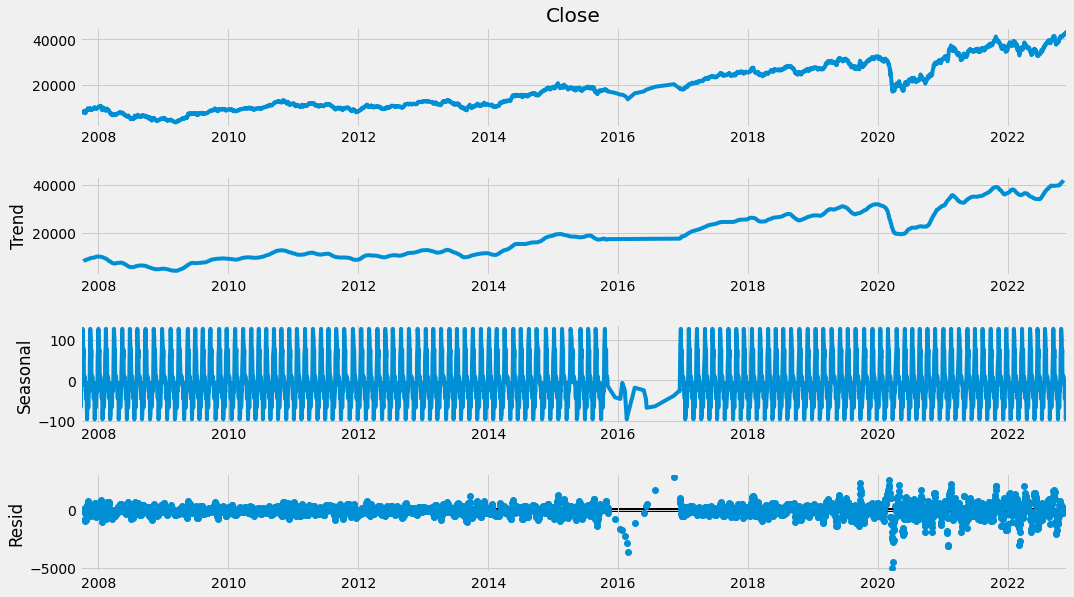

In [34]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df_close, period=30)
#result = seasonal_decompose(df_close, model='multiplicative', freq=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


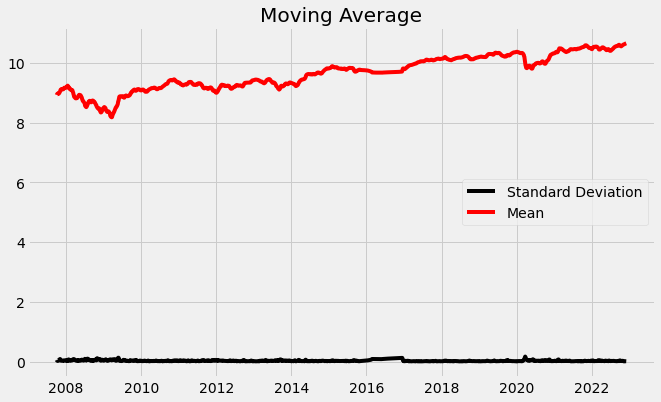

In [35]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

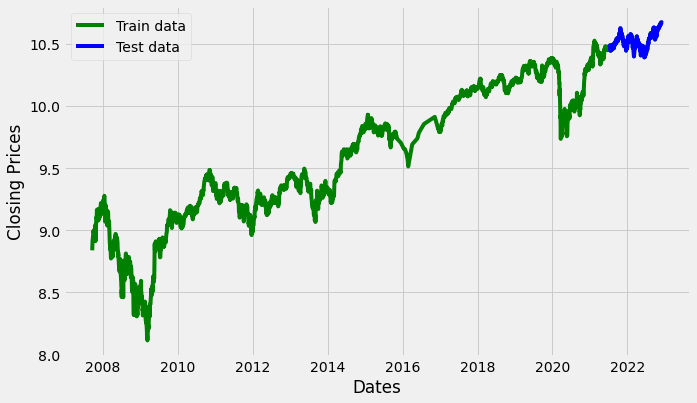

In [36]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15472.582, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15498.433, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15499.431, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15472.632, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15497.710, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15497.805, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15494.643, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-15499.796, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-15498.051, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-15498.132, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-15498.817, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-15496.230, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.807 seconds
                               SARIMAX Results                  

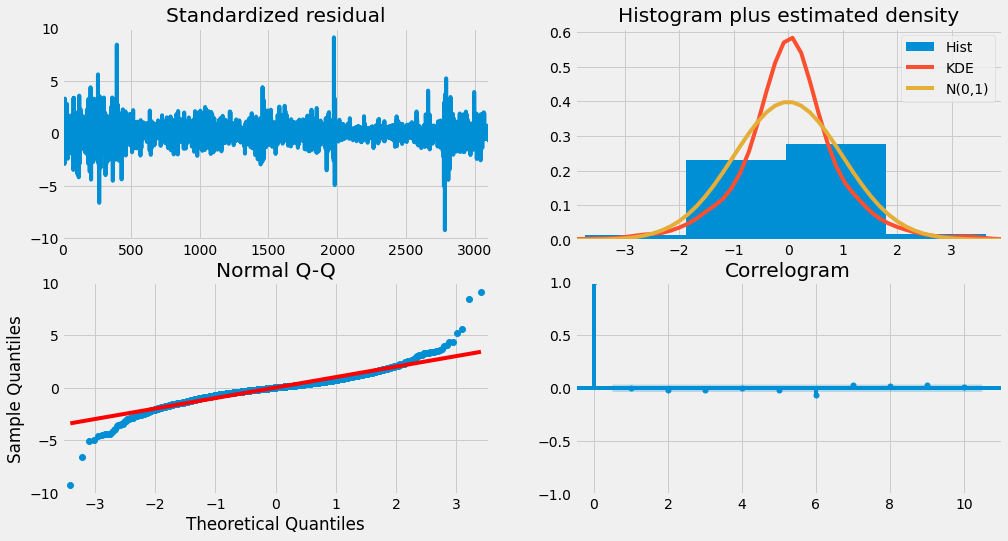

In [37]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 2 respectively.**

In [38]:
#Modeling
# Build Model
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3108
Model:                 ARIMA(1, 1, 2)   Log Likelihood                7752.115
Date:                Mon, 05 Dec 2022   AIC                         -15496.230
Time:                        00:33:51   BIC                         -15472.064
Sample:                             0   HQIC                        -15487.553
                               - 3108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8653      0.111      7.778      0.000       0.647       1.083
ma.L1         -0.7688      0.111     -6.902      0.000      -0.987      -0.551
ma.L2         -0.0973      0.013     -7.410      0.0

### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [39]:
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

In [40]:
print(df_rbl.Date.max())
print(df_rbl.Date.min())

2022-12-02 00:00:00+05:30
2019-12-02 00:00:00+05:30


Plot the results

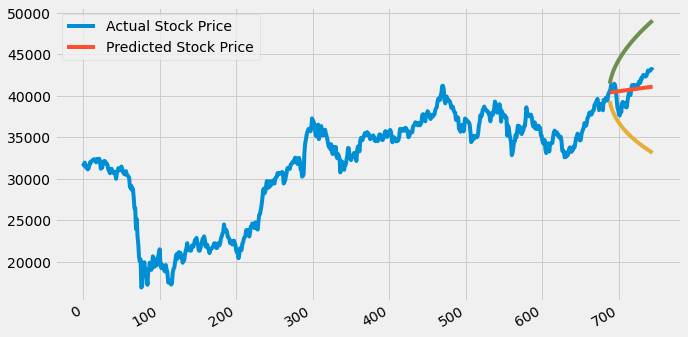

In [44]:


import pandas_datareader.data as web
df=web.DataReader('^NSEBANK', 'yahoo', start='2019-12-02', end='2022-12-02')
total=len(df)
aaa=57
hist=total-aaa
model = sm.tsa.statespace.SARIMAX(df['Close'].values[:hist], trend='c', order=(0,1,0))
fitted = model.fit(disp=False)
result = fitted.forecast(aaa, alpha =0.05)
conf_ins = fitted.get_forecast(aaa).summary_frame()
ind = np.arange(total)
fig, ax = plt.subplots()
ax.plot(ind, df['Close'].values, label='Actual Stock Price')
ax.plot(ind[hist:], result,label='Predicted Stock Price')
ax.plot(ind[hist:], conf_ins['mean_ci_lower'])
ax.plot(ind[hist:], conf_ins['mean_ci_upper'])
ax.legend()
fig.autofmt_xdate()
plt.show()



In [55]:

# report performance
#mse = mean_squared_error(test_data, fc)
#print('MSE: '+str(mse))
#mae = mean_absolute_error(test_data, fc)

##print('MAE: '+str(mae))
#rmse = math.sqrt(mean_squared_error(test_data, fc))
#print('RMSE: '+str(rmse))
#mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
#print('MAPE: '+str(mape))